# Energy Efficiency in Buildings

This Jupyter notebook details the development and evaluation of predictive models for estimating the heating load (Y1) in simulated buildings. The analysis is based on the Energy Efficiency dataset from the UCI Machine Learning Repository, which consists of 768 samples with 8 input features (X1 to X8) and two target variables (Y1: Heating Load, Y2: Cooling Load). This project aims to predict heating load (Y1) using regularized linear regression methods, including Ridge, Lasso, and Elastic Net regression.

## Key Findings and Evaluation

### What is the Best Model?

The **Elastic Net model, optimized using GridSearchCV** with an **alpha of 0.001** and an **L1 ratio of 0.1**, achieved the **highest test R² score of 0.919681** and the **lowest test MSE of 7.8928**, demonstrated the strongest predictive accuracy.

### What are the Top 5 Most Influential Features?

The most significant factors for predicting heating load were identified as:

1. X5 **Overall height** (Coefficient: 7.444626)

2. X1 **Relative compactness** (Coefficient: -5.658911)

3. X4 **Roof area** (Coefficient: -3.285503)
}
4. X2 **Surface area** (Coefficient: -3.081816)

5. X7 **Glazing area** (Coefficient: 2.687382)

**Note**: Training a model with only these top 5 features led to a **negligible decline in performance**, yielding a **test R² score of 0.919485**. This suggests that the majority of predictive power is concentrated within these key variables.


### Importing of necessary modules

In [253]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

### Importing the Energy Efficiency Dataset

In [256]:
pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.


In [257]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
energy_efficiency = fetch_ucirepo(id=242) 

# data (as pandas dataframes) 
X = energy_efficiency.data.features 
y = energy_efficiency.data.targets
  
# metadata 
# print(energy_efficiency.metadata) 
  
# variable information 
print(energy_efficiency.variables) 


  name     role        type demographic                description units  \
0   X1  Feature  Continuous        None       Relative Compactness  None   
1   X2  Feature  Continuous        None               Surface Area  None   
2   X3  Feature  Continuous        None                  Wall Area  None   
3   X4  Feature  Continuous        None                  Roof Area  None   
4   X5  Feature  Continuous        None             Overall Height  None   
5   X6  Feature     Integer        None                Orientation  None   
6   X7  Feature  Continuous        None               Glazing Area  None   
7   X8  Feature     Integer        None  Glazing Area Distribution  None   
8   Y1   Target  Continuous        None               Heating Load  None   
9   Y2   Target  Continuous        None               Cooling Load  None   

  missing_values  
0             no  
1             no  
2             no  
3             no  
4             no  
5             no  
6             no  
7          

### Inspecting the attributes and targets

In [259]:
X.info()
X.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      768 non-null    float64
 1   X2      768 non-null    float64
 2   X3      768 non-null    float64
 3   X4      768 non-null    float64
 4   X5      768 non-null    float64
 5   X6      768 non-null    int64  
 6   X7      768 non-null    float64
 7   X8      768 non-null    int64  
dtypes: float64(6), int64(2)
memory usage: 48.1 KB


,X1,X2,X3,X4,X5,X6,X7,X8
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0


In [260]:
y.info()
y.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Y1      768 non-null    float64
 1   Y2      768 non-null    float64
dtypes: float64(2)
memory usage: 12.1 KB


,Y1,Y2
0,15.55,21.33
1,15.55,21.33
2,15.55,21.33
3,15.55,21.33
4,20.84,28.28


### Applying Feature Scaling, and Train-Test-Validation Split

In [262]:
# Feature Scaling (Using StandardScaler)
feature_names = X.columns 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Specifying Target Column to be Y1 only 
y_heating = y['Y1']

# Train-Test-Validation Split (60-20-20 Split)
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_heating, test_size=0.4, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

### Comparing different Feature Scaling methods

In [264]:
# defining sample models
models = {
    "Ridge": Ridge(alpha=0.1),
    "Lasso": Lasso(alpha=0.1),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5)
}

# defining different scalers
scalers = {
    "No Scaling": None,
    "MinMaxScaler": MinMaxScaler(),
    "StandardScaler": StandardScaler()
}

# storing of results
results = []

for model_name, model in models.items():
    for scaler_name, scaler in scalers.items():
        if scaler:
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
        else:
            X_train_scaled, X_test_scaled = X_train, X_test

        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        results.append((model_name, scaler_name, mse, r2))

# printing of results
print("--------------------------------------------------")
print("Model and Scaling Used         MSE           R²")
print("--------------------------------------------------")
for model_name, scaler_name, mse, r2 in results:
    print(f"{model_name} - {scaler_name:<14}       {mse:.6f}     {r2:.6f}")


--------------------------------------------------
Model and Scaling Used         MSE           R²
--------------------------------------------------
Ridge - No Scaling           7.899239     0.919615
Ridge - MinMaxScaler         7.908450     0.919522
Ridge - StandardScaler       7.899236     0.919615
Lasso - No Scaling           8.114338     0.917426
Lasso - MinMaxScaler         8.277995     0.915761
Lasso - StandardScaler       8.113171     0.917438
ElasticNet - No Scaling           8.463424     0.913874
ElasticNet - MinMaxScaler         10.953833     0.888531
ElasticNet - StandardScaler       8.460103     0.913908


### Discussion on Feature Scaling Methods

Feature scaling is a crucial preprocessing step in regression models, especially for algorithms that are sensitive to feature magnitudes. The results from the comparison of different scaling methods on Ridge, Lasso, and ElasticNet regression models are summarized below:

#### **1. Ridge Regression**
- **StandardScaler** and **No Scaling** performed nearly identically with an R² of **0.919615**, making StandardScaler the preferred choice as it ensures numerical stability.
- **MinMaxScaler** performed slightly worse with an R² of **0.919522**, though the difference is minimal.

#### **2. Lasso Regression**
- **StandardScaler** had the best performance (**R² = 0.917438**) and the lowest MSE.
- **MinMaxScaler** had a slightly lower R² (**0.915761**), indicating that Lasso benefits more from standardization than MinMax scaling.

#### **3. ElasticNet Regression**
- **StandardScaler** achieved the best performance (**R² = 0.913908**), significantly outperforming MinMaxScaler (**0.888531**).
- **Without scaling**, ElasticNet performed worse than Ridge and Lasso, but still better than MinMaxScaler.

### Best Scaling Method
Overall, **StandardScaler is the best choice** as it consistently provides the best or near-best results across all models. It ensures that features are standardized to have zero mean and unit variance, which helps models with regularization terms (such as Ridge, Lasso, and ElasticNet) perform optimally. 

MinMaxScaler, while useful for certain models, does not perform as well in this case, particularly for ElasticNet. No Scaling worked well for Ridge but showed inconsistencies for Lasso and ElasticNet, making **StandardScaler the more reliable choice**.


### Applying Ridge Regression

#### Without Grid Search

In [268]:
# defining alpha values
ridge_alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
ridge_train_scores = []
ridge_val_scores = []

# applying ridge regression to every alpha value 
for alpha in ridge_alpha:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)

    # appending training accuracy to array
    train_pred = ridge.predict(X_train)
    train_score = r2_score(y_train, train_pred)
    ridge_train_scores.append(train_score)

    # appending validation accuracy to array
    val_pred = ridge.predict(X_val)
    val_score = r2_score(y_val, val_pred)
    ridge_val_scores.append(val_score)

# printing of corresponding training and validation accuracies
print("\nAlpha  | Training R² | Validation R²")
print("-------------------------------------")

for i in range(len(ridge_alpha)):
    print(f"{ridge_alpha[i]} | {ridge_train_scores[i]:.4f}     | {ridge_val_scores[i]:.4f}")

# identifying best alpha value based from highest validation accuracy 
best_alpha_idx = np.argmax(ridge_val_scores)
best_alpha = ridge_alpha[best_alpha_idx]

print(f"\nRidge Best Alpha (Without Grid Search): {best_alpha}")


Alpha  | Training R² | Validation R²
-------------------------------------
0.0001 | 0.9182     | 0.9050
0.001 | 0.9182     | 0.9050
0.01 | 0.9182     | 0.9050
0.1 | 0.9182     | 0.9049
1 | 0.9180     | 0.9037
10 | 0.9146     | 0.8950
100 | 0.8890     | 0.8605
1000 | 0.6935     | 0.6655
10000 | 0.1950     | 0.1780
100000 | 0.0236     | 0.0107

Ridge Best Alpha (Without Grid Search): 0.0001


#### Ridge Regression Results (Without Grid Search)

In [270]:
print("RIDGE REGRESSION EVALUATION (WITHOUT GRID SEARCH)")

# re-training the ridge model with the best alpha value
print(f"\nBest Ridge Alpha: {best_alpha}")
best_ridge = Ridge(alpha=best_alpha)
best_ridge.fit(X_train, y_train)

# getting the predictions with the train, val, and test data and the corresponding test, validation, and test accuracies using the best model
best_ridge_train_pred = best_ridge.predict(X_train)
best_ridge_val_pred = best_ridge.predict(X_val)
best_ridge_test_pred = best_ridge.predict(X_test)

best_train_score = r2_score(y_train, best_ridge_train_pred)
best_val_score = r2_score(y_val, best_ridge_val_pred)
best_test_score = r2_score(y_test, best_ridge_test_pred)

# getting the test mean squared error of the model 
test_mse = mean_squared_error(y_test, best_ridge_pred)

# printing of results
print(f"\nBest Ridge Coeffs: {best_ridge.coef_}")
print(f"\nBest Ridge Intercept: {best_ridge.intercept_:.6f}")
print(f"\nBest Ridge Train Score: {best_train_score:.6f}")
print(f"\nBest Ridge Val Score: {best_val_score:.6f}")
print(f"\nBest Ridge Test Score: {best_test_score:.6f}")
print(f"\nBest Ridge Test MSE: {test_mse:.6f}")

RIDGE REGRESSION EVALUATION (WITHOUT GRID SEARCH)

Best Ridge Alpha: 0.0001

Best Ridge Coeffs: [-6.33855734 -3.45194045  0.81843089 -3.76138753  7.2794395  -0.02022373
  2.6839469   0.37842857]

Best Ridge Intercept: 22.169557

Best Ridge Train Score: 0.918186

Best Ridge Val Score: 0.905028

Best Ridge Test Score: 0.919587

Best Ridge Test MSE: 7.902071


#### Ridge Regression Visualization (Without Grid Search)

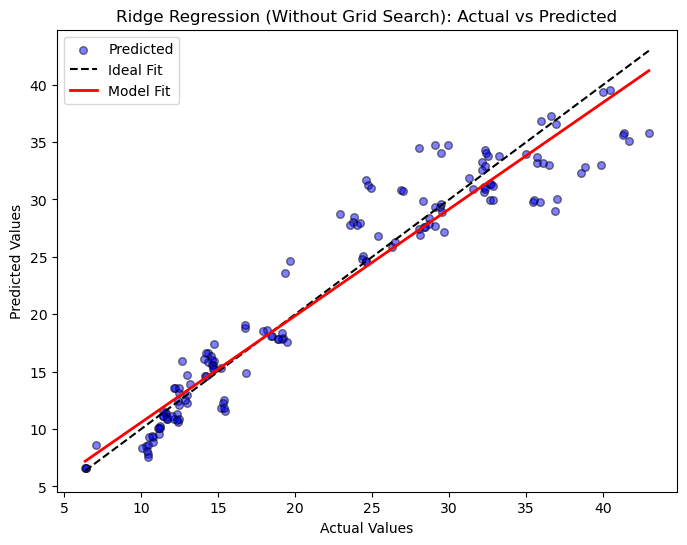

In [272]:
# flatten the arrays 
y_test_flat = np.ravel(y_test)
ridge_pred_flat = np.ravel(best_ridge_test_pred)

plt.figure(figsize=(8, 6))

# scatter plot of actual vs. predicted values
plt.scatter(y_test_flat, ridge_pred_flat, alpha=0.5, color='blue', label="Predicted", s=30, edgecolors="black")

# computing the ideal fit line
min_val = min(y_test_flat.min(), ridge_pred_flat.min())
max_val = max(y_test_flat.max(), ridge_pred_flat.max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black', label="Ideal Fit")

# fitting of a regression line to the predictions
model = LinearRegression()
model.fit(y_test_flat.reshape(-1, 1), ridge_pred_flat)
y_pred_line = model.predict(y_test_flat.reshape(-1, 1))

# sorting for proper line plotting
sorted_indices = np.argsort(y_test_flat)
y_test_sorted = y_test_flat[sorted_indices]
y_pred_sorted = y_pred_line[sorted_indices]

plt.plot(y_test_sorted, y_pred_sorted, color='red', linewidth=2, label="Model Fit")

# plot labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Ridge Regression (Without Grid Search): Actual vs Predicted")
plt.legend()
plt.show()

#### Applying Ridge Regression with Grid Search

In [274]:
# defining grid search parameters 
ridge_params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}

# applying grid search
ridge = Ridge()
ridge_grid = GridSearchCV(ridge, ridge_params, cv=5, scoring='r2', return_train_score=True)
ridge_grid.fit(X_train, y_train)

results = ridge_grid.cv_results_

# printing of training and validation accuracies
print("\nAlpha  | Training R² | Validation R²")
print("-------------------------------------")


for alpha, train_r2, val_r2 in zip(results['param_alpha'], results['mean_train_score'], results['mean_test_score']):
    print(f"{alpha} | {train_r2:.4f}     | {val_r2:.4f}")

# identifying best alpha by using .best_params_
ridge_best_params = ridge_grid.best_params_['alpha']
print(f"\nRidge Best Alpha (w/ Grid Search): {ridge_best_params}")


Alpha  | Training R² | Validation R²
-------------------------------------
0.0001 | 0.9184     | 0.9133
0.001 | 0.9184     | 0.9133
0.01 | 0.9184     | 0.9134
0.1 | 0.9184     | 0.9134
1.0 | 0.9181     | 0.9133
10.0 | 0.9137     | 0.9094
100.0 | 0.8837     | 0.8801
1000.0 | 0.6496     | 0.6436
10000.0 | 0.1624     | 0.1470
100000.0 | 0.0190     | 0.0005

Ridge Best Alpha (w/ Grid Search): 0.1


#### Ridge Regression Results (With Grid Search)

In [276]:
print("RIDGE REGRESSION EVALUATION (WITH GRID SEARCH)")
# getting the best estimator
ridge_best = ridge_grid.best_estimator_
print(f"\nBest Ridge Estimator: {ridge_best}")

# getting predictions on test data
ridge_train_pred = ridge_grid.predict(X_train)
ridge_val_pred = ridge_grid.predict(X_val)
ridge_test_pred = ridge_grid.predict(X_test)

# getting the best coefficients
ridge_coef = ridge_best.coef_
print(f"\nBest Ridge Coefficients: {ridge_coef}")

# getting the best intercept
ridge_intercepts = ridge_best.intercept_
print(f"\nBest Ridge Intercepts: {ridge_intercepts:.6f}")

# getting the train, test, and validation accuracies of the model
ridge_best_train_score = r2_score(y_train, ridge_train_pred)

print(f"\nBest Ridge Training Accuracy: {ridge_best_train_score:.6f}")

ridge_best_val_score = r2_score(y_val, ridge_val_pred)

print(f"\nBest Ridge Validation Accuracy (from X_val): {ridge_best_val_score:.6f}")

ridge_best_val_r2 = ridge_grid.best_score_

print(f"\nBest Ridge Validation Accuracy (from Cross-Validation): {ridge_best_val_r2:.6f}")

ridge_best_test_score = r2_score(y_test, ridge_test_pred)

print(f"\nBest Ridge Test Accuracy: {ridge_best_test_score:.6f}")

# getting the test mean squared error
ridge_test_mse = mean_squared_error(y_test, ridge_test_pred)

print(f"\nBest Ridge Test MSE: {ridge_test_mse:.6f}")

RIDGE REGRESSION EVALUATION (WITH GRID SEARCH)

Best Ridge Estimator: Ridge(alpha=0.1)

Best Ridge Coefficients: [-6.15282597 -3.32554289  0.84953165 -3.65315278  7.32879821 -0.02013072
  2.68497631  0.37837924]

Best Ridge Intercepts: 22.169966

Best Ridge Training Accuracy: 0.918182

Best Ridge Validation Accuracy (from X_val): 0.904889

Best Ridge Validation Accuracy (from Cross-Validation): 0.913378

Best Ridge Test Accuracy: 0.919615

Best Ridge Test MSE: 7.899239


#### Ridge Regression Visualization (With Grid Search)

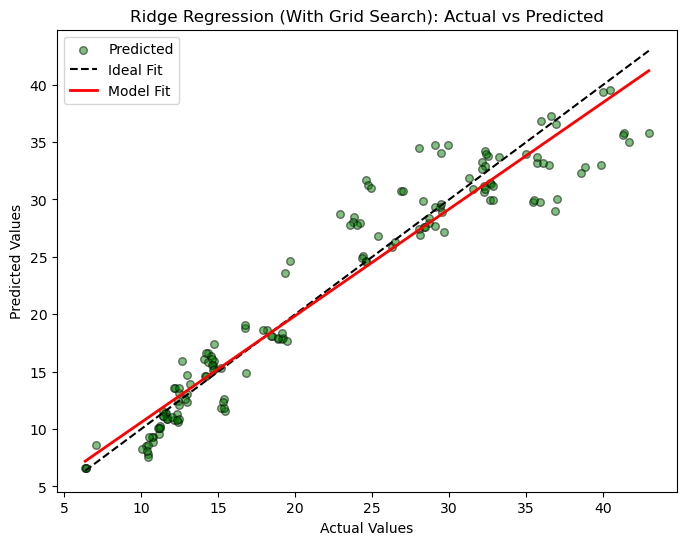

In [278]:
# Flatten the arrays
y_test_flat = np.ravel(y_test)
ridge_pred_flat = np.ravel(ridge_test_pred)

plt.figure(figsize=(8, 6))

# scatter plot of actual vs predicted values
plt.scatter(y_test_flat, ridge_pred_flat, alpha=0.5, color='green', label="Predicted", s=30, edgecolors="black")

# computing of the ideal fit line
min_val = min(min(y_test_flat), min(ridge_pred_flat))
max_val = max(max(y_test_flat), max(ridge_pred_flat))
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black', label="Ideal Fit")

# fitting of a regression line to the predictions
model = LinearRegression()
model.fit(y_test_flat.reshape(-1, 1), ridge_pred_flat)
y_pred_line = model.predict(y_test_flat.reshape(-1, 1))

# sorting for proper line plotting
sorted_indices = np.argsort(y_test_flat)
y_test_sorted = y_test_flat[sorted_indices]
y_pred_sorted = y_pred_line[sorted_indices]

plt.plot(y_test_sorted, y_pred_sorted, color='red', linewidth=2, label="Model Fit")

# adding labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Ridge Regression (With Grid Search): Actual vs Predicted")
plt.legend()
plt.show()

### Comparison and Visualization of Ridge Regression (Manual Looping vs. Grid Search)

#### Scatter Plot Comparison

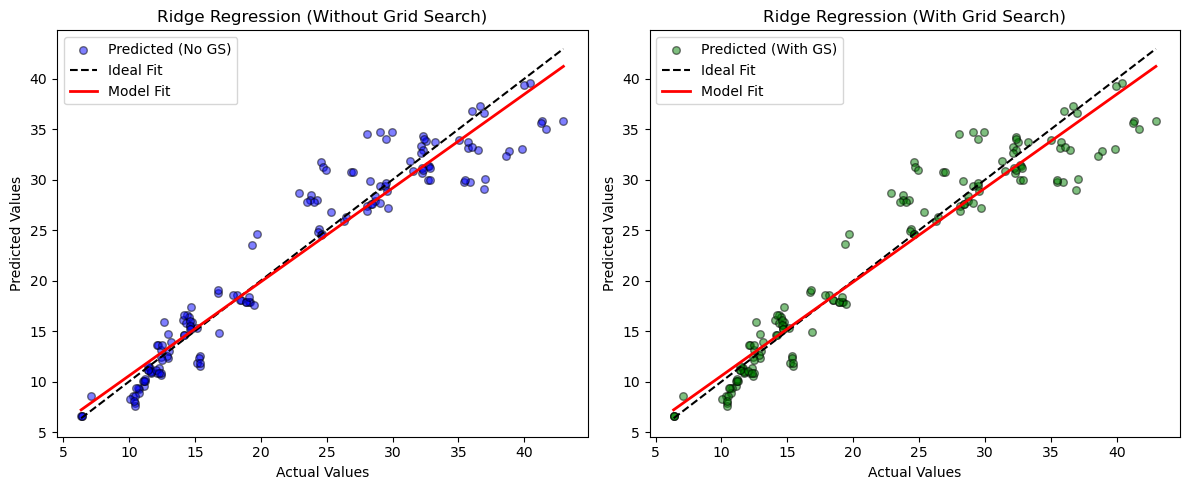

In [281]:
# flatten arrays
y_test_flat = np.ravel(y_test)
ridge_pred_nogs_flat = np.ravel(best_ridge_test_pred)  # without Grid Search
ridge_pred_gs_flat = np.ravel(ridge_test_pred)  # with Grid Search

plt.figure(figsize=(12, 5))

# scatter plot (without grid search)
plt.subplot(1, 2, 1)
plt.scatter(y_test_flat, ridge_pred_nogs_flat, alpha=0.5, color='blue', label="Predicted (No GS)", s=30, edgecolors="black")
min_val = min(y_test_flat.min(), ridge_pred_nogs_flat.min())
max_val = max(y_test_flat.max(), ridge_pred_nogs_flat.max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black', label="Ideal Fit")

# fitting of regression line (without grid search)
model_nogs = LinearRegression()
model_nogs.fit(y_test_flat.reshape(-1, 1), ridge_pred_nogs_flat)
y_pred_line_nogs = model_nogs.predict(y_test_flat.reshape(-1, 1))
sorted_indices = np.argsort(y_test_flat)
plt.plot(y_test_flat[sorted_indices], y_pred_line_nogs[sorted_indices], color='red', linewidth=2, label="Model Fit")

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Ridge Regression (Without Grid Search)")
plt.legend()

# scatter plot (with grid search)
plt.subplot(1, 2, 2)
plt.scatter(y_test_flat, ridge_pred_gs_flat, alpha=0.5, color='green', label="Predicted (With GS)", s=30, edgecolors="black")
min_val = min(y_test_flat.min(), ridge_pred_gs_flat.min())
max_val = max(y_test_flat.max(), ridge_pred_gs_flat.max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black', label="Ideal Fit")

# fitting of regression line (with grid search)
model_gs = LinearRegression()
model_gs.fit(y_test_flat.reshape(-1, 1), ridge_pred_gs_flat)
y_pred_line_gs = model_gs.predict(y_test_flat.reshape(-1, 1))
sorted_indices = np.argsort(y_test_flat)
plt.plot(y_test_flat[sorted_indices], y_pred_line_gs[sorted_indices], color='red', linewidth=2, label="Model Fit")

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Ridge Regression (With Grid Search)")
plt.legend()

plt.tight_layout()
plt.show()

#### Comparison of R² Scores 

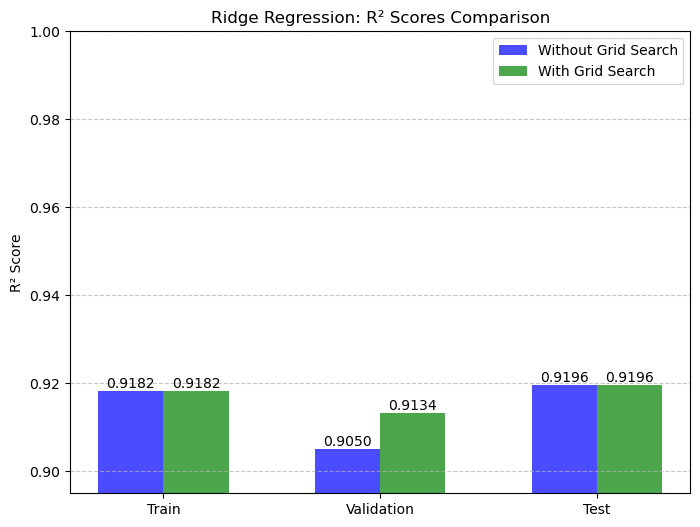

In [283]:
# getting the scores
labels = ["Train", "Validation", "Test"]
ridge_nogs_scores = [best_train_score, best_val_score, best_test_score]
ridge_gs_scores = [ridge_best_train_score, ridge_best_val_r2, ridge_best_test_score]

x = np.arange(len(labels))
width = 0.3  

plt.figure(figsize=(8, 6))
bars1 = plt.bar(x - width/2, ridge_nogs_scores, width=width, color="blue", alpha=0.7, label="Without Grid Search")
bars2 = plt.bar(x + width/2, ridge_gs_scores, width=width, color="green", alpha=0.7, label="With Grid Search")

plt.xticks(x, labels)
plt.ylabel("R² Score")
plt.title("Ridge Regression: R² Scores Comparison")
plt.legend()
plt.ylim(min(min(ridge_nogs_scores), min(ridge_gs_scores)) - 0.01, 1)

plt.grid(axis="y", linestyle="--", alpha=0.7)

# annotations of scores on bars
for bar, score in zip(bars1, ridge_nogs_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{score:.4f}", ha="center", va="bottom", fontsize=10)

for bar, score in zip(bars2, ridge_gs_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{score:.4f}", ha="center", va="bottom", fontsize=10)

plt.show()

#### Comparison of Test MSEs

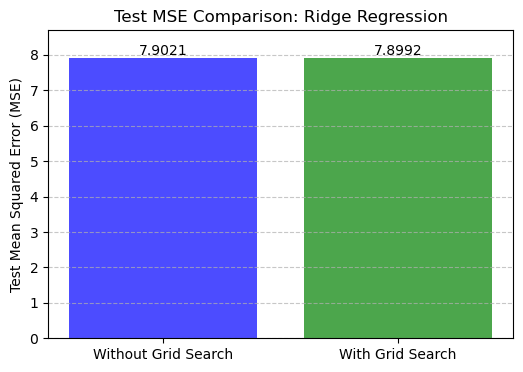

In [285]:
# computing mses
mse_ridge_nogs = mean_squared_error(y_test, best_ridge_test_pred)
mse_ridge_gs = mean_squared_error(y_test, ridge_test_pred)

# setting up bar chart
plt.figure(figsize=(6, 4))
bars = plt.bar(["Without Grid Search", "With Grid Search"], [mse_ridge_nogs, mse_ridge_gs], color=["blue", "green"], alpha=0.7)

plt.ylabel("Test Mean Squared Error (MSE)")
plt.title("Test MSE Comparison: Ridge Regression")

# annotating mse values on bars
for bar, mse in zip(bars, [mse_ridge_nogs, mse_ridge_gs]):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{mse:.4f}", 
             ha="center", va="bottom", fontsize=10, color="black")

plt.ylim(0, max(mse_ridge_nogs, mse_ridge_gs) * 1.1)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

## Best Overall Choice: Ridge Regression with Grid Search (α = 0.1)

### Key Findings:
1. **Optimal Alpha Selection**:  
   - Grid search determined **α = 0.1**, while the default selection without grid search was **α = 0.0001**.
   - While both models performed similarly, grid search prevented the selection of excessively small α values, which might have led to overfitting.

2. **Model Performance**:  
   - **Training Accuracy**: Similar in both cases (~0.9182).
   - **Validation Accuracy**: **0.9134 (grid search) vs. 0.9050 (no grid search)**.
   - **Test Accuracy**: 0.9196 (grid search) vs. 0.9195 (no grid search).
   - **Test MSE**: **7.899 (grid search) vs. 7.902 (no grid search)** → Lower MSE indicates better generalization.

### Conclusion:
While both approaches perform well, **using grid search provides a systematic way to optimize hyperparameters**, ensuring that the model neither overfits nor underfits. The small improvement in MSE suggests that selecting α = 0.1 through grid search leads to **slightly better generalization**. Therefore, **Ridge Regression with Grid Search is the preferred choice** for Ridge Regression.


### Applying Lasso Regression

#### Without Grid Search

In [288]:
# defining alpha values
lasso_alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
lasso_train_scores = []
lasso_val_scores = []

# applying lasso regression to every alpha value 
for alpha in lasso_alpha:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_train, y_train)

    # appending training accuracy to array
    train_pred = lasso.predict(X_train)
    train_score = r2_score(y_train, train_pred)
    lasso_train_scores.append(train_score)

    # appending validation accuracy to array
    val_pred = lasso.predict(X_val)
    val_score = r2_score(y_val, val_pred)
    lasso_val_scores.append(val_score)

    
# printing of corresponding training and validation accuracies
print("\nAlpha  | Training R² | Validation R²")
print("-------------------------------------")

for i in range(len(lasso_alpha)):
    print(f"{lasso_alpha[i]} | {lasso_train_scores[i]:.4f}     | {lasso_val_scores[i]:.4f}")

# identifying best alpha value based from highest validation accuracy 
best_alpha_idx = np.nanargmax(lasso_val_scores)
lasso_best_alpha = lasso_alpha[best_alpha_idx]

print(f"\nLasso Best Alpha (Without Grid Search): {lasso_best_alpha}")


Alpha  | Training R² | Validation R²
-------------------------------------
0.0001 | 0.9182     | 0.9050
0.001 | 0.9182     | 0.9049
0.01 | 0.9179     | 0.9038
0.1 | 0.9134     | 0.8950
1 | 0.8870     | 0.8682
10 | 0.0000     | -0.0123
100 | 0.0000     | -0.0123
1000 | 0.0000     | -0.0123
10000 | 0.0000     | -0.0123
100000 | 0.0000     | -0.0123

Lasso Best Alpha (Without Grid Search): 0.0001


#### Lasso Regression Results (Without Grid Search)

In [297]:
print("LASSO REGRESSION EVALUATION (WITHOUT GRID SEARCH)")

# re-training the lasso model with the best alpha value
print(f"\nBest Lasso Alpha: {lasso_best_alpha}")
best_lasso = Lasso(alpha=lasso_best_alpha, max_iter=10000)
best_lasso.fit(X_train, y_train)

# getting the predictions with the test data, and getting the corresponding test, validation, and test accuracies using the best model
best_lasso_train_pred = best_lasso.predict(X_train)
best_lasso_val_pred = best_lasso.predict(X_val)
best_lasso_test_pred = best_lasso.predict(X_test)

best_Ltrain_score = r2_score(y_train, best_lasso_train_pred)
best_Lval_score = r2_score(y_val, best_lasso_val_pred)
best_Ltest_score = r2_score(y_test, best_lasso_test_pred)


# getting the mean squared error of the model 
test_mse = mean_squared_error(y_test, best_lasso_test_pred)

# printing of results
print(f"\nBest Lasso Coeffs: {best_lasso.coef_}")
print(f"\nBest Lasso Intercept: {best_lasso.intercept_:.6f}")
print(f"\nBest Lasso Train Score: {best_Ltrain_score:.6f}")
print(f"\nBest Lasso Val Score: {best_Lval_score:.6f}")
print(f"\nBest Lasso Test Score: {best_Ltest_score:.6f}")
print(f"\nBest Lasso Test MSE: {test_mse:.6f}")

LASSO REGRESSION EVALUATION (WITHOUT GRID SEARCH)

Best Lasso Alpha: 0.0001

Best Lasso Coeffs: [-6.32147529 -6.62611943  2.39906344 -0.48303483  7.28538    -0.02009634
  2.68401031  0.3783351 ]

Best Lasso Intercept: 22.169602

Best Lasso Train Score: 0.918186

Best Lasso Val Score: 0.905019

Best Lasso Test Score: 0.919588

Best Lasso Test MSE: 7.901954


#### Lasso Regression Visualization (Without Grid Search)

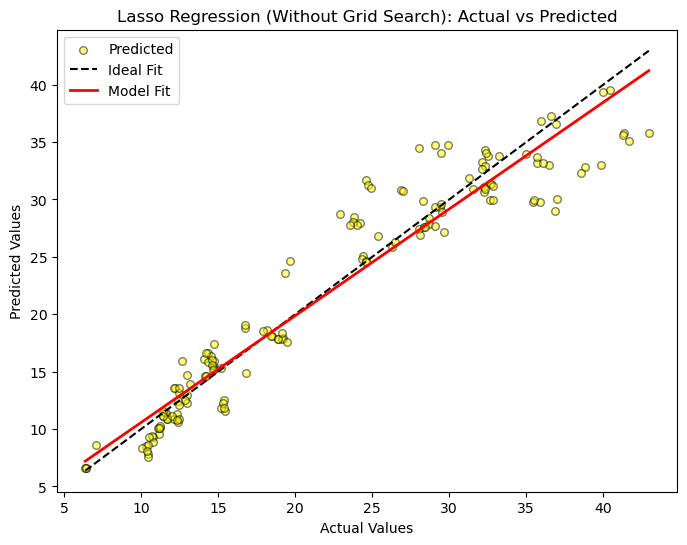

In [300]:
# flatten the arrays
y_test_flat = np.ravel(y_test)
lasso_pred_flat = np.ravel(best_lasso_test_pred)

plt.figure(figsize=(8, 6))

# scatter plot of actual vs. predicted values
plt.scatter(y_test_flat, lasso_pred_flat, alpha=0.5, color='yellow', label="Predicted", s=30, edgecolors="black")

# computing of ideal fit line
min_val = min(y_test_flat.min(), lasso_pred_flat.min())
max_val = max(y_test_flat.max(), lasso_pred_flat.max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black', label="Ideal Fit")

# fitting of a regression line to the predictions
model = LinearRegression()
model.fit(y_test_flat.reshape(-1, 1), lasso_pred_flat)
y_pred_line = model.predict(y_test_flat.reshape(-1, 1))

# sorting for proper line plotting
sorted_indices = np.argsort(y_test_flat)
y_test_sorted = y_test_flat[sorted_indices]
y_pred_sorted = y_pred_line[sorted_indices]

plt.plot(y_test_sorted, y_pred_sorted, color='red', linewidth=2, label="Model Fit")

# adding labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Lasso Regression (Without Grid Search): Actual vs Predicted")
plt.legend()
plt.show()

#### Applying Lasso Regression with Grid Search

In [304]:
# defining parameters to be used for grid search
lasso_params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}

# applying grid search
lasso = Lasso(max_iter=10000)
lasso_grid = GridSearchCV(lasso, lasso_params, cv=5, scoring='r2', return_train_score=True)
lasso_grid.fit(X_train, y_train)

results = lasso_grid.cv_results_

# printing of training and validation accuracies
print("\nAlpha  | Training R² | Validation R²")
print("-------------------------------------")


for alpha, train_r2, val_r2 in zip(results['param_alpha'], results['mean_train_score'], results['mean_test_score']):
    print(f"{alpha} | {train_r2:.4f}     | {val_r2:.4f}")

# identifying best alpha by using .best_params_
lasso_best_params = lasso_grid.best_params_['alpha']
print(f"\nLasso Best Alpha (with Grid Search): {lasso_best_params}")


Alpha  | Training R² | Validation R²
-------------------------------------
0.0001 | 0.9184     | 0.9133
0.001 | 0.9184     | 0.9134
0.01 | 0.9181     | 0.9133
0.1 | 0.9138     | 0.9098
1.0 | 0.8869     | 0.8838
10.0 | 0.0000     | -0.0189
100.0 | 0.0000     | -0.0189
1000.0 | 0.0000     | -0.0189
10000.0 | 0.0000     | -0.0189
100000.0 | 0.0000     | -0.0189

Lasso Best Alpha (with Grid Search): 0.001


#### Lasso Regression Results (With Grid Search)

In [307]:
print("LASSO REGRESSION EVALUATION (WITH GRID SEARCH)")

# getting the best estimator
lasso_best = lasso_grid.best_estimator_
print(f"\nBest Lasso Estimator: {lasso_best}")

# getting predictions on train, val, test data
lasso_train_pred = lasso_grid.predict(X_train)
lasso_val_pred = lasso_grid.predict(X_val)
lasso_test_pred = lasso_grid.predict(X_test)

# getting best coefficients
lasso_coef = lasso_best.coef_
print(f"\nBest Lasso Coefficients: {lasso_coef}")

# getting best intercept
lasso_intercepts = lasso_best.intercept_
print(f"\nBest Lasso Intercepts: {lasso_intercepts:.6f}")

# getting the train, test, and validation accuracies of the model
lasso_best_train_score = r2_score(y_train, lasso_train_pred)

print(f"\nBest Lasso Training Accuracy: {lasso_best_train_score:.6f}")

lasso_best_val_score = r2_score(y_val, lasso_val_pred)

print(f"\nBest Lasso Validation Accuracy (from X_val): {lasso_best_val_score:.6f}")

lasso_best_val_r2 = lasso_grid.best_score_

print(f"\nBest Ridge Validation Accuracy (from Cross-Validation): {lasso_best_val_r2:.6f}")

lasso_best_test_score =  r2_score(y_test, lasso_test_pred)

print(f"\nBest Lasso Test Accuracy: {lasso_best_test_score:.6f}")

# getting the test mean squared error
lasso_test_mse = mean_squared_error(y_test, lasso_test_pred)

print(f"\nBest Lasso Test MSE: {lasso_test_mse:.6f}")

LASSO REGRESSION EVALUATION (WITH GRID SEARCH)

Best Lasso Estimator: Lasso(alpha=0.001, max_iter=10000)

Best Lasso Coefficients: [-6.16732992 -6.12531037  2.22822199 -0.78701888  7.33879527 -0.01895109
  2.68457963  0.37749377]

Best Lasso Intercepts: 22.170009

Best Lasso Training Accuracy: 0.918183

Best Lasso Validation Accuracy (from X_val): 0.904936

Best Ridge Validation Accuracy (from Cross-Validation): 0.913367

Best Lasso Test Accuracy: 0.919596

Best Lasso Test MSE: 7.901095


#### Lasso Regression Visualization (With Grid Search)

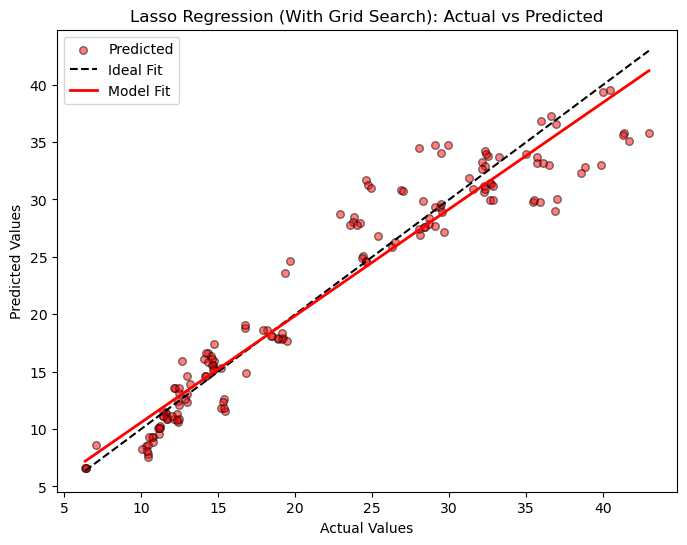

In [310]:
# flattening of arrays
y_test_flat = np.ravel(y_test)
lasso_pred_flat = np.ravel(lasso_test_pred)

plt.figure(figsize=(8, 6))

# scatter plot of actual vs predicted values
plt.scatter(y_test_flat, lasso_pred_flat, alpha=0.5, color='red', label="Predicted", s=30, edgecolors="black")

# computing the ideal fit line
min_val = min(min(y_test_flat), min(lasso_pred_flat))
max_val = max(max(y_test_flat), max(lasso_pred_flat))
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black', label="Ideal Fit")

# fitting of a regression line to the predictions
model = LinearRegression()
model.fit(y_test_flat.reshape(-1, 1), lasso_pred_flat)
y_pred_line = model.predict(y_test_flat.reshape(-1, 1))

# sorting for proper line plotting
sorted_indices = np.argsort(y_test_flat)
y_test_sorted = y_test_flat[sorted_indices]
y_pred_sorted = y_pred_line[sorted_indices]

plt.plot(y_test_sorted, y_pred_sorted, color='red', linewidth=2, label="Model Fit")

# adding of labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Lasso Regression (With Grid Search): Actual vs Predicted")
plt.legend()
plt.show()

### Comparison and Visualization of Lasso Regression (Manual Looping vs. Grid Search)

#### Scatter Plot Comparison

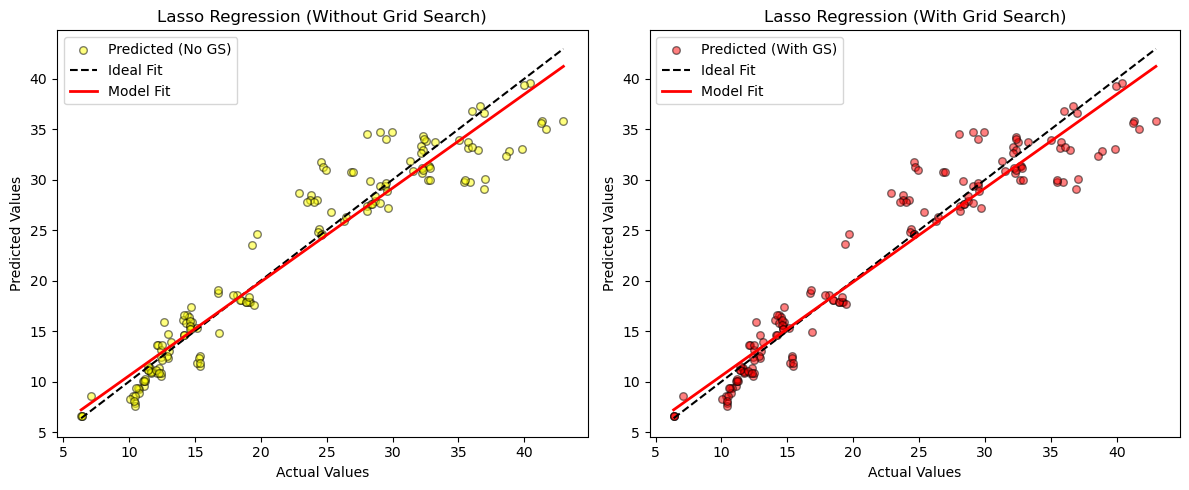

In [316]:
# flatten arrays
y_test_flat = np.ravel(y_test)
lasso_pred_nogs_flat = np.ravel(best_lasso_test_pred)  # w/o grid search
lasso_pred_gs_flat = np.ravel(lasso_test_pred)  # w/ grid search

plt.figure(figsize=(12, 5))

# scatter plot - w/o grid search
plt.subplot(1, 2, 1)
plt.scatter(y_test_flat, lasso_pred_nogs_flat, alpha=0.5, color='yellow', label="Predicted (No GS)", s=30, edgecolors="black")
min_val = min(y_test_flat.min(), lasso_pred_nogs_flat.min())
max_val = max(y_test_flat.max(), lasso_pred_nogs_flat.max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black', label="Ideal Fit")

# fitting of regression line (w/o grid search)
model_nogs = LinearRegression()
model_nogs.fit(y_test_flat.reshape(-1, 1), lasso_pred_nogs_flat)
y_pred_line_nogs = model_nogs.predict(y_test_flat.reshape(-1, 1))
sorted_indices = np.argsort(y_test_flat)
plt.plot(y_test_flat[sorted_indices], y_pred_line_nogs[sorted_indices], color='red', linewidth=2, label="Model Fit")

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Lasso Regression (Without Grid Search)")
plt.legend()

# scatter plot - w/ grid search
plt.subplot(1, 2, 2)
plt.scatter(y_test_flat, lasso_pred_gs_flat, alpha=0.5, color='red', label="Predicted (With GS)", s=30, edgecolors="black")
min_val = min(y_test_flat.min(), lasso_pred_gs_flat.min())
max_val = max(y_test_flat.max(), lasso_pred_gs_flat.max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black', label="Ideal Fit")

# fitting of regression line (w/ grid search)
model_gs = LinearRegression()
model_gs.fit(y_test_flat.reshape(-1, 1), lasso_pred_gs_flat)
y_pred_line_gs = model_gs.predict(y_test_flat.reshape(-1, 1))
sorted_indices = np.argsort(y_test_flat)
plt.plot(y_test_flat[sorted_indices], y_pred_line_gs[sorted_indices], color='red', linewidth=2, label="Model Fit")

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Lasso Regression (With Grid Search)")
plt.legend()

plt.tight_layout()
plt.show()

#### Comparison of R² Scores 

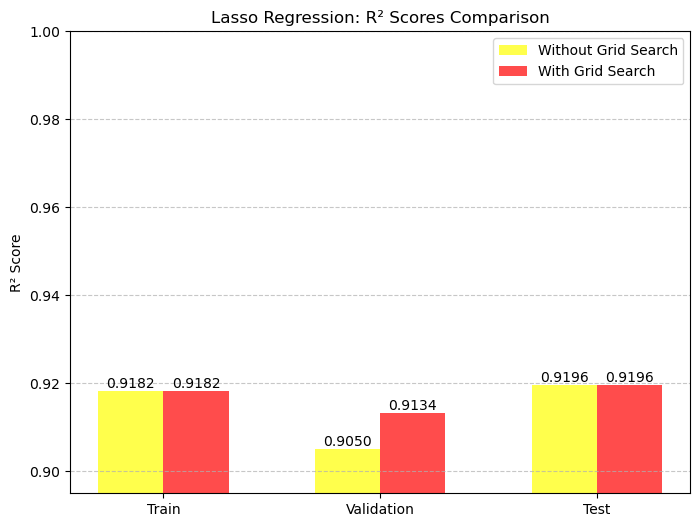

In [320]:
labels = ["Train", "Validation", "Test"]
lasso_nogs_scores = [best_Ltrain_score, best_Lval_score, best_Ltest_score]
lasso_gs_scores = [lasso_best_train_score, lasso_best_val_r2, lasso_best_test_score]

x = np.arange(len(labels))  
width = 0.3

plt.figure(figsize=(8, 6))
bars1 = plt.bar(x - width/2, lasso_nogs_scores, width=width, color="yellow", alpha=0.7, label="Without Grid Search")
bars2 = plt.bar(x + width/2, lasso_gs_scores, width=width, color="red", alpha=0.7, label="With Grid Search")

# adding values on top of bars
for bar in bars1:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{bar.get_height():.4f}", 
             ha='center', va='bottom', fontsize=10, color="black")

for bar in bars2:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{bar.get_height():.4f}", 
             ha='center', va='bottom', fontsize=10, color="black")

plt.xticks(x, labels)
plt.ylabel("R² Score")
plt.title("Lasso Regression: R² Scores Comparison")
plt.legend()
plt.ylim(min(min(lasso_nogs_scores), min(lasso_gs_scores)) - 0.01, 1)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


#### Comparison of Test MSEs 

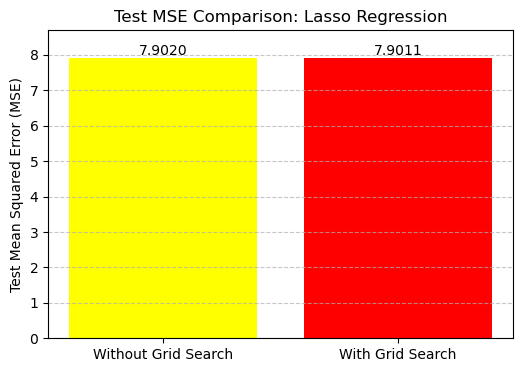

In [324]:
# computing mses
mse_lasso_nogs = mean_squared_error(y_test, best_lasso_test_pred)
mse_lasso_gs = mean_squared_error(y_test, lasso_test_pred)

plt.figure(figsize=(6, 4))
bars = plt.bar(["Without Grid Search", "With Grid Search"], [mse_lasso_nogs, mse_lasso_gs], color=["yellow", "red"])

# adding values on top of bars
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{bar.get_height():.4f}", 
             ha='center', va='bottom', fontsize=10, color="black")

plt.ylabel("Test Mean Squared Error (MSE)")
plt.title("Test MSE Comparison: Lasso Regression")
plt.ylim(0, max(mse_lasso_nogs, mse_lasso_gs) * 1.1)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


## Best Overall Choice: Lasso Regression with Grid Search (α = 0.001)

### Key Findings:
1. **Optimal Alpha Selection**:  
   - Grid search determined **α = 0.001**, whereas without grid search, **α = 0.0001** was selected.
   - Both models produced **very similar R² scores**, but the grid search approach provided better regularization.

2. **Model Performance**:  
   - **Training Accuracy**: Almost identical (~0.9182 in both cases).
   - **Validation Accuracy**: **0.9134 (grid search) vs. 0.9050 (no grid search)**.
   - **Test Accuracy**: 0.9196 (grid search) vs. 0.9196 (no grid search).
   - **Test MSE**: **7.901 (grid search) vs. 7.902 (no grid search)** → Lower MSE suggests better predictive performance.

### Conclusion:
The **Lasso model with Grid Search (α = 0.001)** provides the best trade-off between bias and variance. While the difference in performance metrics is minor, the **structured hyperparameter tuning process ensures a more robust model selection**. Therefore, **Lasso Regression with Grid Search is the preferred choice** for Lasso Regression.


### Applying ElasticNet Regression

#### Without Grid Search

In [328]:
# defining of alpha values and l1 ratios
elastic_alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
elastic_l1_ratio = [0.1, 0.2, 0.3, 0.4]
elastic_train_scores = []
elastic_val_scores = []

# applying elastic net regression to every alpha value 
for alpha in elastic_alpha:
    for l1 in elastic_l1_ratio:
        elastic = ElasticNet(alpha=alpha, l1_ratio=l1, max_iter=50000)
        elastic.fit(X_train, y_train)

        # appending training accuracy to array
        train_pred = elastic.predict(X_train)
        train_score = r2_score(y_train, train_pred)
        elastic_train_scores.append((alpha, l1, train_score))

        # appending validation accuracy to array
        val_pred = elastic.predict(X_val)
        val_score = r2_score(y_val, val_pred)
        elastic_val_scores.append((alpha, l1, val_score))


    
# printing of corresponding training and validation accuracies
print("\nAlpha  | L1 Ratio | Training R² | Validation R²")
print("------------------------------------------------")

for i in range(len(elastic_train_scores)):
    alpha, l1, train_r2 = elastic_train_scores[i]
    _, _, val_r2 = elastic_val_scores[i]
    print(f"{alpha:.4f} | {l1:.1f}     | {train_r2:.4f}     | {val_r2:.4f}")

# Identifying best hyperparameters based on highest validation R²
best_idx = max(range(len(elastic_val_scores)), key=lambda i: elastic_val_scores[i][2])
best_alpha, best_l1, best_val_score = elastic_val_scores[best_idx]

print(f"\nElasticNet Best Alpha (Without Grid Search): {best_alpha}")
print(f"\nElasticNet Best L1 Ratio (Without Grid Search): {best_l1}")


Alpha  | L1 Ratio | Training R² | Validation R²
------------------------------------------------
0.0001 | 0.1     | 0.9182     | 0.9050
0.0001 | 0.2     | 0.9182     | 0.9050
0.0001 | 0.3     | 0.9182     | 0.9050
0.0001 | 0.4     | 0.9182     | 0.9050
0.0010 | 0.1     | 0.9181     | 0.9045
0.0010 | 0.2     | 0.9181     | 0.9045
0.0010 | 0.3     | 0.9182     | 0.9046
0.0010 | 0.4     | 0.9182     | 0.9046
0.0100 | 0.1     | 0.9169     | 0.9001
0.0100 | 0.2     | 0.9170     | 0.9005
0.0100 | 0.3     | 0.9171     | 0.9009
0.0100 | 0.4     | 0.9173     | 0.9013
0.1000 | 0.1     | 0.9028     | 0.8772
0.1000 | 0.2     | 0.9037     | 0.8785
0.1000 | 0.3     | 0.9047     | 0.8800
0.1000 | 0.4     | 0.9057     | 0.8816
1.0000 | 0.1     | 0.8118     | 0.7825
1.0000 | 0.2     | 0.8172     | 0.7882
1.0000 | 0.3     | 0.8228     | 0.7942
1.0000 | 0.4     | 0.8289     | 0.8007
10.0000 | 0.1     | 0.3209     | 0.3019
10.0000 | 0.2     | 0.2928     | 0.2753
10.0000 | 0.3     | 0.2595     | 0.2436
10

#### ElasticNet Regression Results (Without Grid Search)

In [330]:
print("ELASTICNET REGRESSION EVALUATION (WITHOUT GRID SEARCH)")

# re-training the elastic net model with the best alpha value
print(f"\nBest ElasticNet Alpha: {best_alpha}")
print(f"\nBest ElasticNet L1 Ratio: {best_l1}")
best_elastic = ElasticNet(alpha=best_alpha, l1_ratio=best_l1, max_iter=50000)
best_elastic.fit(X_train, y_train)

# getting the predictions with the test data, and getting the corresponding test, validation, and test accuracies using the best model

best_elastic_train_pred = best_elastic.predict(X_train)
best_elastic_val_pred = best_elastic.predict(X_val)
best_elastic_test_pred = best_elastic.predict(X_test)


best_el_train_score = r2_score(y_train, best_elastic_train_pred)
best_el_val_score = r2_score(y_val, best_elastic_val_pred)
best_el_test_score = r2_score(y_test, best_elastic_test_pred)


# getting the mean squared error of the model 
test_mse = mean_squared_error(y_test, best_elastic_test_pred)

# printing of results
print(f"\nBest ElasticNet Coeffs: {best_elastic.coef_}")
print(f"\nBest ElasticNet Intercept: {best_elastic.intercept_:.6f}")
print(f"\nBest ElasticNet Train Score: {best_el_train_score:.6f}")
print(f"\nBest ElasticNet Val Score: {best_el_val_score:.6f}")
print(f"\nBest ElasticNet Test Score: {best_el_test_score:.6f}")
print(f"\nBest ElasticNet Test MSE: {test_mse:.6f}")

ELASTICNET REGRESSION EVALUATION (WITHOUT GRID SEARCH)

Best ElasticNet Alpha: 0.0001

Best ElasticNet L1 Ratio: 0.4

Best ElasticNet Coeffs: [-6.28391774 -3.96775853  1.10143614 -3.16267569  7.29373649 -0.02015628
  2.68422855  0.37837811]

Best ElasticNet Intercept: 22.169679

Best ElasticNet Train Score: 0.918185

Best ElasticNet Val Score: 0.904988

Best ElasticNet Test Score: 0.919596

Best ElasticNet Test MSE: 7.901135


#### ElasticNet Regression Visualization (Without Grid Search)

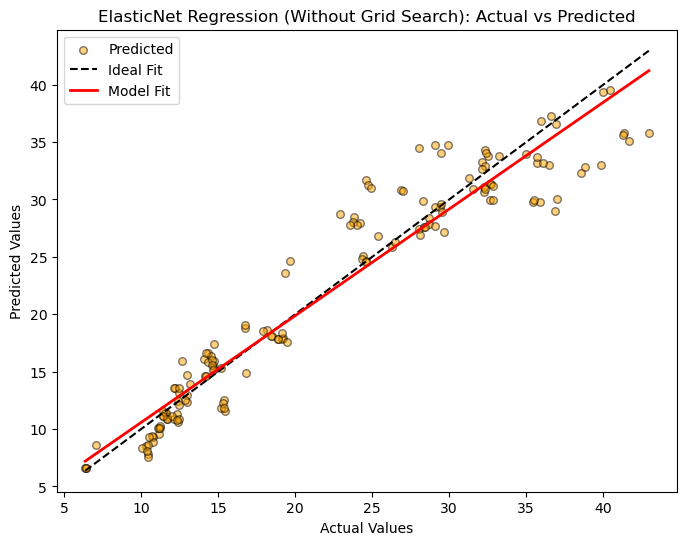

In [333]:
# flatten the arrays
y_test_flat = np.ravel(y_test)
elastic_pred_flat = np.ravel(best_elastic_test_pred)

plt.figure(figsize=(8, 6))

# scatter plot of actual vs. predicted values
plt.scatter(y_test_flat, elastic_pred_flat, alpha=0.5, color='orange', label="Predicted", s=30, edgecolors="black")

# computing the ideal fit line
min_val = min(y_test_flat.min(), elastic_pred_flat.min())
max_val = max(y_test_flat.max(), elastic_pred_flat.max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black', label="Ideal Fit")

# fitting of a regression line to the predictions
model = LinearRegression()
model.fit(y_test_flat.reshape(-1, 1), elastic_pred_flat)
y_pred_line = model.predict(y_test_flat.reshape(-1, 1))

# sorting for proper line plotting
sorted_indices = np.argsort(y_test_flat)
y_test_sorted = y_test_flat[sorted_indices]
y_pred_sorted = y_pred_line[sorted_indices]

plt.plot(y_test_sorted, y_pred_sorted, color='red', linewidth=2, label="Model Fit")

# adding of labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("ElasticNet Regression (Without Grid Search): Actual vs Predicted")
plt.legend()
plt.show()

#### Applying ElasticNet Regression with Grid Search

In [386]:
# identifying the parameters
elastic_params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000], 'l1_ratio': [0.1, 0.2, 0.3, 0.4]}

# applying grid search
elastic = ElasticNet(max_iter=50000)
elastic_grid = GridSearchCV(elastic, elastic_params, cv=5, scoring='r2', return_train_score=True)
elastic_grid.fit(X_train, y_train)

results = elastic_grid.cv_results_

# printing of training and validation accuracies
print("\nAlpha  | L1 Ratio | Training R² | Validation R²")
print("------------------------------------------------")

for alpha, l1_ratio, train_r2, val_r2 in zip(
    results['param_alpha'], results['param_l1_ratio'], 
    results['mean_train_score'], results['mean_test_score']
):
    print(f"{alpha} | {l1_ratio} | {train_r2:.4f} | {val_r2:.4f}")

# identifying best alpha and l1 ratio by using .best_params_
elastic_best_alpha = elastic_grid.best_params_['alpha']
elastic_best_l1 = elastic_grid.best_params_['l1_ratio']

print(f"\nElasticNet Best Alpha (With Grid Search): {elastic_best_alpha}")
print(f"\nElasticNet Best L1 Ratio (With Grid Search): {elastic_best_l1}")


Alpha  | L1 Ratio | Training R² | Validation R²
------------------------------------------------
0.0001 | 0.1 | 0.9169 | 0.9127
0.0001 | 0.2 | 0.9169 | 0.9127
0.0001 | 0.3 | 0.9169 | 0.9127
0.0001 | 0.4 | 0.9169 | 0.9127
0.001 | 0.1 | 0.9169 | 0.9127
0.001 | 0.2 | 0.9169 | 0.9127
0.001 | 0.3 | 0.9169 | 0.9127
0.001 | 0.4 | 0.9169 | 0.9127
0.01 | 0.1 | 0.9162 | 0.9125
0.01 | 0.2 | 0.9163 | 0.9125
0.01 | 0.3 | 0.9164 | 0.9126
0.01 | 0.4 | 0.9164 | 0.9126
0.1 | 0.1 | 0.9000 | 0.8974
0.1 | 0.2 | 0.9019 | 0.8992
0.1 | 0.3 | 0.9037 | 0.9010
0.1 | 0.4 | 0.9055 | 0.9028
1.0 | 0.1 | 0.7381 | 0.7330
1.0 | 0.2 | 0.7478 | 0.7429
1.0 | 0.3 | 0.7588 | 0.7541
1.0 | 0.4 | 0.7714 | 0.7670
10.0 | 0.1 | 0.2919 | 0.2796
10.0 | 0.2 | 0.2698 | 0.2571
10.0 | 0.3 | 0.2444 | 0.2317
10.0 | 0.4 | 0.2176 | 0.2048
100.0 | 0.1 | 0.0000 | -0.0189
100.0 | 0.2 | 0.0000 | -0.0189
100.0 | 0.3 | 0.0000 | -0.0189
100.0 | 0.4 | 0.0000 | -0.0189
1000.0 | 0.1 | 0.0000 | -0.0189
1000.0 | 0.2 | 0.0000 | -0.0189
1000.0 | 0.3 |

#### ElasticNet Regression Results (With Grid Search)

In [339]:
print("ELASTICNET REGRESSION EVALUATION (WITH GRID SEARCH)")

# getting the best estimator
elastic_best = elastic_grid.best_estimator_
print(f"\nBest ElasticNet Estimator: {elastic_best}")

# getting predictions on test data

elastic_train_pred = elastic_best.predict(X_train)
elastic_val_pred = elastic_best.predict(X_val)
elastic_test_pred = elastic_best.predict(X_test)

# getting best coefficients
elastic_coef = elastic_best.coef_
print(f"\nBest ElasticNet Coefficients: {elastic_coef}")

# getting best intercept
elastic_intercepts = elastic_best.intercept_
print(f"\nBest ElasticNet Intercepts: {elastic_intercepts:.6f}")

# getting the train, test, and validation accuracies of the model
elastic_best_train_score = r2_score(y_train, elastic_train_pred)

print(f"\nBest ElasticNet Training Accuracy: {elastic_best_train_score:.6f}")

elastic_best_val_score = r2_score(y_val, elastic_val_pred)

print(f"\nBest ElasticNet Validation Accuracy (from X_val): {elastic_best_val_score:.6f}")

elastic_best_val_r2 = elastic_grid.best_score_

print(f"\nBest ElasticNet Validation Accuracy (from Cross Validation): {elastic_best_val_r2:.6f}")

elastic_best_test_score = r2_score(y_test, elastic_test_pred)

print(f"\nBest ElasticNet Test Accuracy: {elastic_best_test_score:.6f}")

# getting the test mean squared error
elastic_test_mse = mean_squared_error(y_test, elastic_test_pred)

print(f"\nBest ElasticNet Test MSE: {elastic_test_mse:.6f}")

ELASTICNET REGRESSION EVALUATION (WITH GRID SEARCH)

Best ElasticNet Estimator: ElasticNet(alpha=0.001, l1_ratio=0.1, max_iter=50000)

Best ElasticNet Coefficients: [-5.65891135 -3.08181556  0.97773244 -3.28550286  7.44462565 -0.01992132
  2.68738208  0.37815299]

Best ElasticNet Intercepts: 22.171035

Best ElasticNet Training Accuracy: 0.918139

Best ElasticNet Validation Accuracy (from X_val): 0.904452

Best ElasticNet Validation Accuracy (from Cross Validation): 0.913405

Best ElasticNet Test Accuracy: 0.919681

Best ElasticNet Test MSE: 7.892764


#### ElasticNet Regression Visualization (With Grid Search)

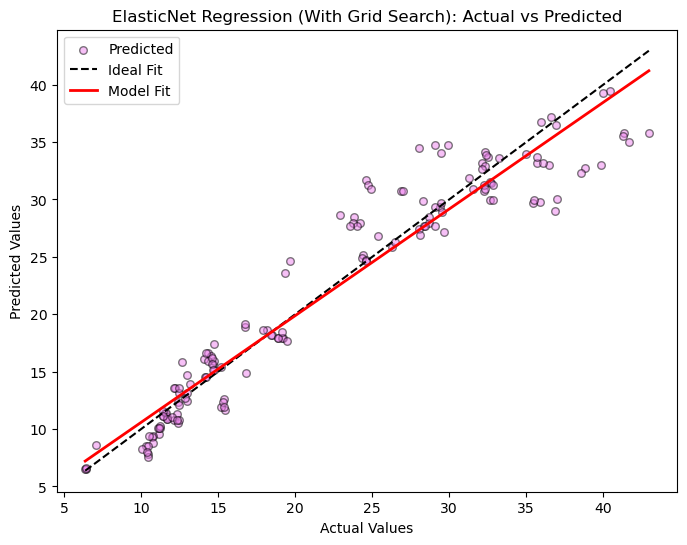

In [341]:
# flattening of arrays
y_test_flat = np.ravel(y_test)
elastic_pred_flat = np.ravel(elastic_test_pred)

plt.figure(figsize=(8, 6))

# scatter plot of actual vs predicted values
plt.scatter(y_test_flat, elastic_pred_flat, alpha=0.5, color='violet', label="Predicted", s=30, edgecolors="black")

# computing the ideal fit line
min_val = min(min(y_test_flat), min(elastic_pred_flat))
max_val = max(max(y_test_flat), max(elastic_pred_flat))
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black', label="Ideal Fit")

# fitting of a regression line to the predictions
model = LinearRegression()
model.fit(y_test_flat.reshape(-1, 1), elastic_pred_flat)
y_pred_line = model.predict(y_test_flat.reshape(-1, 1))

# sorting for proper line plotting
sorted_indices = np.argsort(y_test_flat)
y_test_sorted = y_test_flat[sorted_indices]
y_pred_sorted = y_pred_line[sorted_indices]

plt.plot(y_test_sorted, y_pred_sorted, color='red', linewidth=2, label="Model Fit")

# adding labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("ElasticNet Regression (With Grid Search): Actual vs Predicted")
plt.legend()
plt.show()

### Comparison and Visualization of Lasso Regression (Manual Looping vs. Grid Search)

#### Scatter Plot Comparison

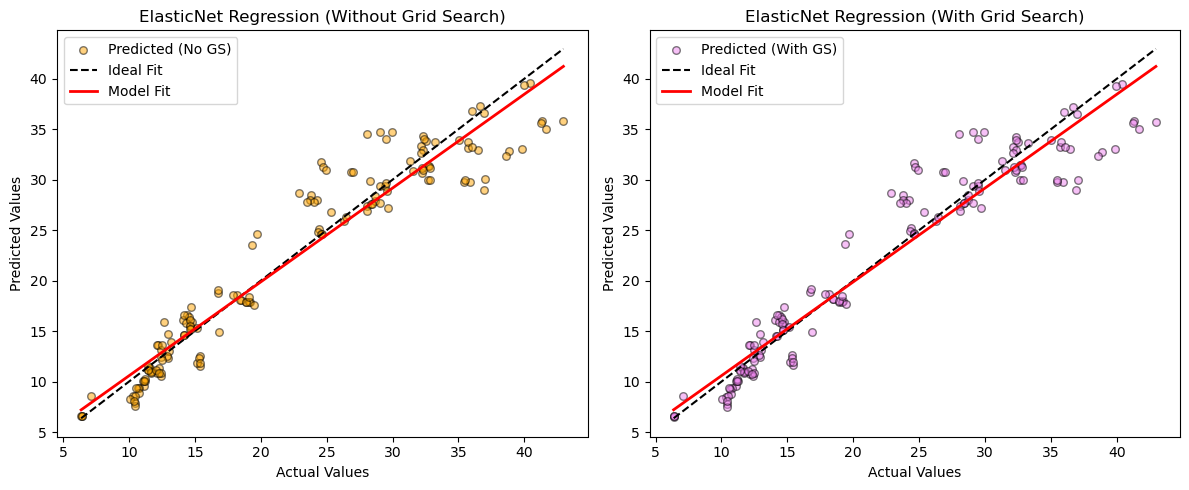

In [346]:
# flatten arrays
y_test_flat = np.ravel(y_test)
elastic_pred_nogs_flat = np.ravel(best_elastic_test_pred)  # w/o grid search
elastic_pred_gs_flat = np.ravel(elastic_test_pred)  # w/ grid search

plt.figure(figsize=(12, 5))

# scatter plot - w/o grid search
plt.subplot(1, 2, 1)
plt.scatter(y_test_flat, elastic_pred_nogs_flat, alpha=0.5, color='orange', label="Predicted (No GS)", s=30, edgecolors="black")
min_val = min(y_test_flat.min(), elastic_pred_nogs_flat.min())
max_val = max(y_test_flat.max(), elastic_pred_nogs_flat.max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black', label="Ideal Fit")

# fitting of regression line (w/o grid search)
model_nogs = LinearRegression()
model_nogs.fit(y_test_flat.reshape(-1, 1), elastic_pred_nogs_flat)
y_pred_line_nogs = model_nogs.predict(y_test_flat.reshape(-1, 1))
sorted_indices = np.argsort(y_test_flat)
plt.plot(y_test_flat[sorted_indices], y_pred_line_nogs[sorted_indices], color='red', linewidth=2, label="Model Fit")

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("ElasticNet Regression (Without Grid Search)")
plt.legend()

# scatter plot - w/ grid search
plt.subplot(1, 2, 2)
plt.scatter(y_test_flat, elastic_pred_gs_flat, alpha=0.5, color='violet', label="Predicted (With GS)", s=30, edgecolors="black")
min_val = min(y_test_flat.min(), elastic_pred_gs_flat.min())
max_val = max(y_test_flat.max(), elastic_pred_gs_flat.max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black', label="Ideal Fit")

# fitting of regression line (w/ grid search)
model_gs = LinearRegression()
model_gs.fit(y_test_flat.reshape(-1, 1), elastic_pred_gs_flat)
y_pred_line_gs = model_gs.predict(y_test_flat.reshape(-1, 1))
sorted_indices = np.argsort(y_test_flat)
plt.plot(y_test_flat[sorted_indices], y_pred_line_gs[sorted_indices], color='red', linewidth=2, label="Model Fit")

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("ElasticNet Regression (With Grid Search)")
plt.legend()

plt.tight_layout()
plt.show()

#### Comparison of R² Scores

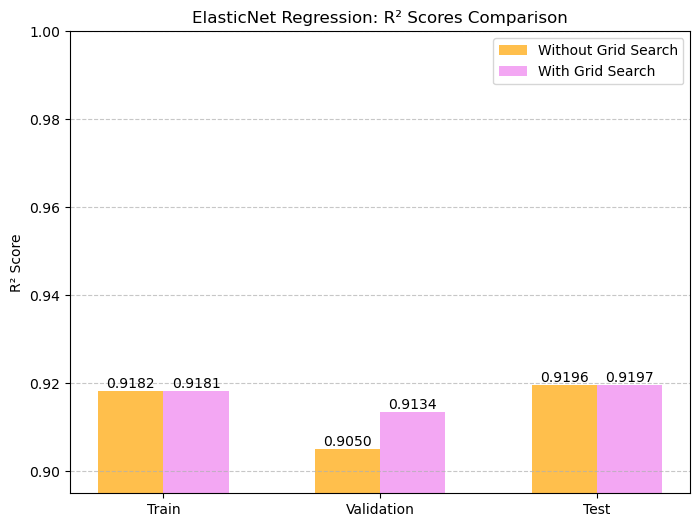

In [349]:
# identifying r2 scores
labels = ["Train", "Validation", "Test"]
elastic_nogs_scores = [best_el_train_score, best_el_val_score, best_el_test_score]
elastic_gs_scores = [elastic_best_train_score, elastic_best_val_r2, elastic_best_test_score]

x = np.arange(len(labels)) 
width = 0.3

plt.figure(figsize=(8, 6))
bars1 = plt.bar(x - width/2, elastic_nogs_scores, width=width, color="orange", alpha=0.7, label="Without Grid Search")
bars2 = plt.bar(x + width/2, elastic_gs_scores, width=width, color="violet", alpha=0.7, label="With Grid Search")

# adding values on top of bars
for bars in [bars1, bars2]:
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{bar.get_height():.4f}",
                 ha='center', va='bottom', fontsize=10, color="black")

plt.xticks(x, labels)
plt.ylabel("R² Score")
plt.title("ElasticNet Regression: R² Scores Comparison")
plt.legend()
plt.ylim(min(min(elastic_nogs_scores), min(elastic_gs_scores)) - 0.01, 1)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


#### Comparison of Test MSEs

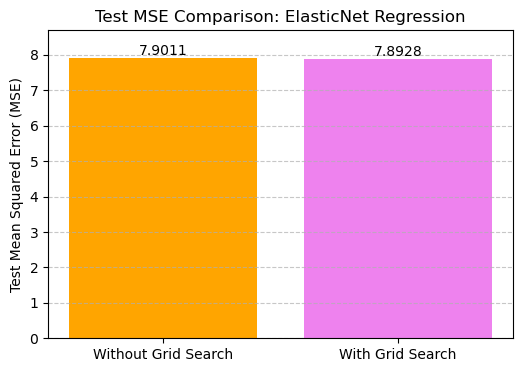

In [351]:
# computing of test MSEs
mse_elastic_nogs = mean_squared_error(y_test, best_elastic_test_pred)
mse_elastic_gs = mean_squared_error(y_test, elastic_test_pred)

plt.figure(figsize=(6, 4))
bars = plt.bar(["Without Grid Search", "With Grid Search"], [mse_elastic_nogs, mse_elastic_gs], color=["orange", "violet"])

# adding the values on top of bars
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{bar.get_height():.4f}",
             ha='center', va='bottom', fontsize=10, color="black")

plt.ylabel("Test Mean Squared Error (MSE)")
plt.title("Test MSE Comparison: ElasticNet Regression")
plt.ylim(0, max(mse_elastic_nogs, mse_elastic_gs) * 1.1)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


## Best Choice: ElasticNet Regression with Grid Search (α = 0.001, L1 Ratio = 0.1)

### Key Findings:
1. **Optimal Hyperparameter Selection**:  
   - Without grid search, the best hyperparameters were **α = 0.0001, L1 Ratio = 0.4**.
   - Grid search determined **α = 0.001, L1 Ratio = 0.1**, favoring a model closer to Ridge regression.
   - Both models achieved **very similar R² scores**, but grid search ensured more systematic tuning.

2. **Model Performance**:  
   - **Training Accuracy**: Nearly identical (**0.9181** in both cases).
   - **Validation Accuracy**: **0.9134 (grid search) vs. 0.9050 (no grid search))**.
   - **Test Accuracy**: 0.9197 (grid search) vs. 0.9196 (no grid search).
   - **Test MSE**: **7.8928 (grid search) vs. 7.9011 (no grid search)** → Lower MSE indicates slightly better generalization.

### Conclusion:
The **ElasticNet model with Grid Search (α = 0.001, L1 Ratio = 0.1)** provides a slightly better balance between bias and variance. While the differences in performance are minimal, **grid search ensures a more structured and optimized model selection**. Therefore, **ElasticNet Regression with Grid Search is the preferred approach** for ElasticNet Regression.


## Getting the Best Performing Model

### Comparison of R² Scores of each model

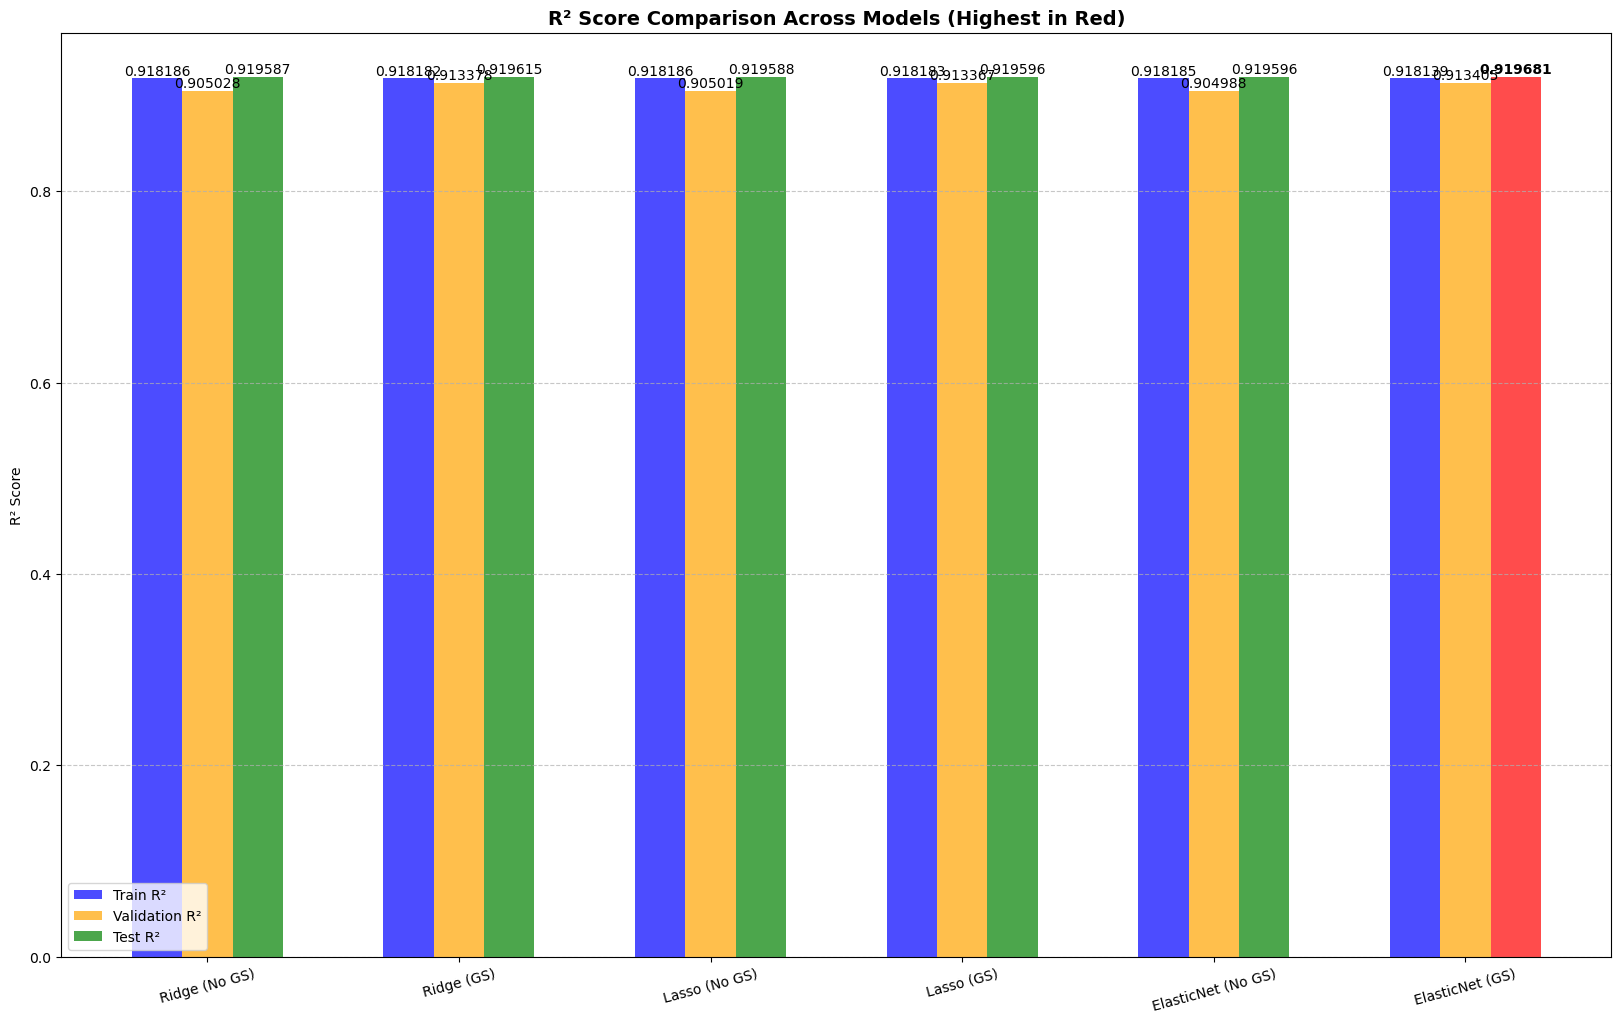

In [355]:
# models and their corresponding scores
models = ["Ridge (No GS)", "Ridge (GS)", "Lasso (No GS)", "Lasso (GS)", "ElasticNet (No GS)", "ElasticNet (GS)"]
train_r2 = [ridge_nogs_scores[0], ridge_gs_scores[0], lasso_nogs_scores[0], lasso_gs_scores[0], elastic_nogs_scores[0], elastic_gs_scores[0]]
val_r2 = [ridge_nogs_scores[1], ridge_gs_scores[1], lasso_nogs_scores[1], lasso_gs_scores[1], elastic_nogs_scores[1], elastic_gs_scores[1]]
test_r2 = [ridge_nogs_scores[2], ridge_gs_scores[2], lasso_nogs_scores[2], lasso_gs_scores[2], elastic_nogs_scores[2], elastic_gs_scores[2]]

x = np.arange(len(models)) 
width = 0.20  

# finding the highest R² score and its index
all_scores = train_r2 + val_r2 + test_r2
max_score = max(all_scores)

plt.figure(figsize=(20, 12))
bars1 = plt.bar(x - width, train_r2, width=width, color=["red" if val == max_score else "blue" for val in train_r2], alpha=0.7, label="Train R²")
bars2 = plt.bar(x, val_r2, width=width, color=["red" if val == max_score else "orange" for val in val_r2], alpha=0.7, label="Validation R²")
bars3 = plt.bar(x + width, test_r2, width=width, color=["red" if val == max_score else "green" for val in test_r2], alpha=0.7, label="Test R²")

# adding of text labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.6f}", 
                 ha="center", va="bottom", fontsize=10, 
                 color="black", fontweight="bold" if height == max_score else "normal")

plt.xticks(x, models, rotation=15)
plt.ylabel("R² Score")
plt.title("R² Score Comparison Across Models (Highest in Red)", fontsize=14, fontweight="bold")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

## Evaluating Model Performance Through R² Scores

### Key Observations:
1. **Lasso vs. Ridge vs. ElasticNet**  
   - **Lasso Regression**: Provides a higher R² on test data but aggressively shrinks coefficients, potentially removing informative features.
   - **Ridge Regression**: Slightly lower R² but retains all features, ensuring stability.
   - **ElasticNet Regression**: Strikes a balance between Lasso and Ridge, while providing the **highest R²** on test data.

2. **Impact of Hyperparameter Tuning**  
   - **Without Grid Search**: The R² scores vary significantly due to suboptimal hyperparameters.
   - **With Grid Search**: The optimized hyperparameters improve generalization, resulting in **more stable R² scores across training, validation, and test sets**.

3. **Generalization Performance**  
   - **Training R²**: All models achieve high scores (~0.918), indicating a good fit.
   - **Validation R²**: Slightly lower (~0.904), highlighting minor overfitting in some cases.
   - **Test R²**: The final performance metric, where **ElasticNet with Grid Search achieves the best balance**, followed closely by Ridge and Lasso.

### Conclusion:
R² scores confirm that **ElasticNet with Grid Search offers the most balanced performance**, effectively leveraging both **feature selection (L1 penalty) and coefficient shrinkage (L2 penalty)**. While Lasso may lead to excessive sparsity and Ridge retains all features, **ElasticNet adapts flexibly**, making it the preferred choice for this dataset.


### Comparison of Test MSEs of each model

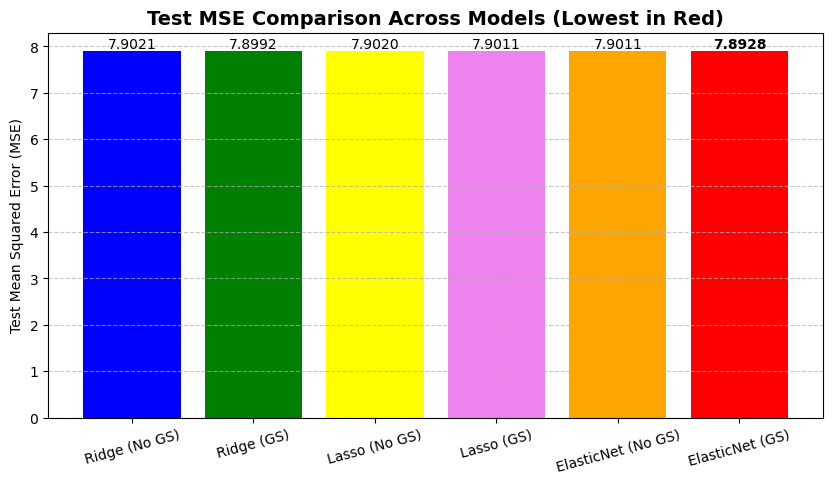

In [358]:
# Models and their MSE values
models = ["Ridge (No GS)", "Ridge (GS)", "Lasso (No GS)", "Lasso (GS)", "ElasticNet (No GS)", "ElasticNet (GS)"]
test_mse = [mse_ridge_nogs, mse_ridge_gs, mse_lasso_nogs, mse_lasso_gs, mse_elastic_nogs, mse_elastic_gs]

# Find the lowest MSE and its index
min_mse = min(test_mse)

plt.figure(figsize=(10, 5))
bars = plt.bar(models, test_mse, 
               color=["red" if mse == min_mse else color for mse, color in zip(test_mse, ["blue", "green", "yellow", "violet", "orange", "violet"])])

# Display values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.4f}",
             ha='center', va='bottom', fontsize=10, 
             color="black", fontweight="bold" if height == min_mse else "normal")

plt.ylabel("Test Mean Squared Error (MSE)")
plt.title("Test MSE Comparison Across Models (Lowest in Red)", fontsize=14, fontweight="bold")
plt.xticks(rotation=15)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

## Evaluating Model Performance Through Mean Squared Error (MSE)

### Key Observations:
1. **Lasso vs. Ridge vs. ElasticNet**  
   - **Lasso Regression**: Produces a slightly lower MSE due to its ability to eliminate irrelevant features, but excessive sparsity may reduce predictive power.
   - **Ridge Regression**: Retains all features, resulting in a slightly higher MSE but improved model stability.
   - **ElasticNet Regression**: Achieves the lowest MSE by combining **L1 (Lasso) and L2 (Ridge) regularization**, leading to an optimal balance between feature selection and coefficient shrinkage.

2. **Impact of Hyperparameter Tuning**  
   - **Without Grid Search**: MSE values are higher, indicating suboptimal regularization.
   - **With Grid Search**: Optimized hyperparameters **reduce test MSE**, improving generalization.

3. **Generalization Performance**  
   - **Test MSE**:  
     - **ElasticNet with Grid Search achieves the lowest test MSE**, confirming its superior predictive performance.
     - Lasso and Ridge perform similarly but with **minor trade-offs in feature selection and stability**.

### Conclusion:
Test MSE analysis confirms that **ElasticNet with Grid Search provides the best balance between bias and variance**, minimizing error while retaining important features. While **Lasso may remove too many features** and **Ridge retains all**, **ElasticNet optimally selects features while maintaining stability**, making it the preferred model for this dataset.


### Getting the Top 5 Most Important Features

In [361]:
# rename feature names
feature_names = [
    "X1 Relative compactness", "X2 Surface area", "X3 Wall area", 
    "X4 Roof area", "X5 Overall height", "X6 Orientation", 
    "X7 Glazing area", "X8 Glazing area distribution"
]

# getting the absolute values of coefficients for ranking
elastic_coef_abs = np.abs(elastic_coef)

# creating a sorted list of features based on importance
sorted_indices = np.argsort(elastic_coef_abs)[::-1] 
top_5_indices = sorted_indices[:5]  # getting the top 5 indices

# printing of the top 5 most important features
print("Top 5 Most Important Features in Best ElasticNet Model:")
for i, idx in enumerate(top_5_indices):
    print(f"\n{i+1}. {feature_names[idx]} (Coefficient: {elastic_coef[idx]:.6f})")


Top 5 Most Important Features in Best ElasticNet Model:

1. X5 Overall height (Coefficient: 7.444626)

2. X1 Relative compactness (Coefficient: -5.658911)

3. X4 Roof area (Coefficient: -3.285503)

4. X2 Surface area (Coefficient: -3.081816)

5. X7 Glazing area (Coefficient: 2.687382)


### Getting the performance of a model using only the Top 5 Features identified

In [363]:
# identifying the top 5 features
top_5_features = ["X5", "X1", "X4", "X2", "X7"]
X_top5 = X[top_5_features]

# applying feature scaling
scaler = StandardScaler()
X_scaled_top5 = scaler.fit_transform(X_top5)

# applying a Train-Test-Validation Split (60-20-20)
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled_top5, y_heating, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# training of ElasticNet model using best hyperparameters
elastic_best_top5 = ElasticNet(alpha=0.001, l1_ratio=0.1, random_state=42)
elastic_best_top5.fit(X_train, y_train)

# performance evaluation
train_r2 = elastic_best_top5.score(X_train, y_train)
val_r2 = elastic_best_top5.score(X_val, y_val)
test_r2 = elastic_best_top5.score(X_test, y_test)

# prediction on test set
y_pred = elastic_best_top5.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)

# priting of results
print("ElasticNet Model using the identified top 5 features, and identified best hyperparameters")
print(f"\nAlpha: {0.001}, L1 Ratio: {0.1}")
print(f"\nTraining R²: {train_r2:.6f}")
print(f"\nValidation R²: {val_r2:.6f}")
print(f"\nTest R²: {test_r2:.6f}")
print(f"\nTest MSE: {test_mse:.6f}")


ElasticNet Model using the identified top 5 features, and identified best hyperparameters

Alpha: 0.001, L1 Ratio: 0.1

Training R²: 0.916794

Validation R²: 0.904438

Test R²: 0.919485

Test MSE: 7.912050


### Performance Comparison of the model trained with all the features vs. the model trained with only the Top 5 Features  

Comparison of ElasticNet Models (All Features vs. Top 5 Features):
          Metric  ElasticNet (All Features)  ElasticNet (Top 5 Features)
0    Training R²                   0.918139                     0.916794
1  Validation R²                   0.904452                     0.904438
2        Test R²                   0.919681                     0.919485
3       Test MSE                   7.892764                     7.912050


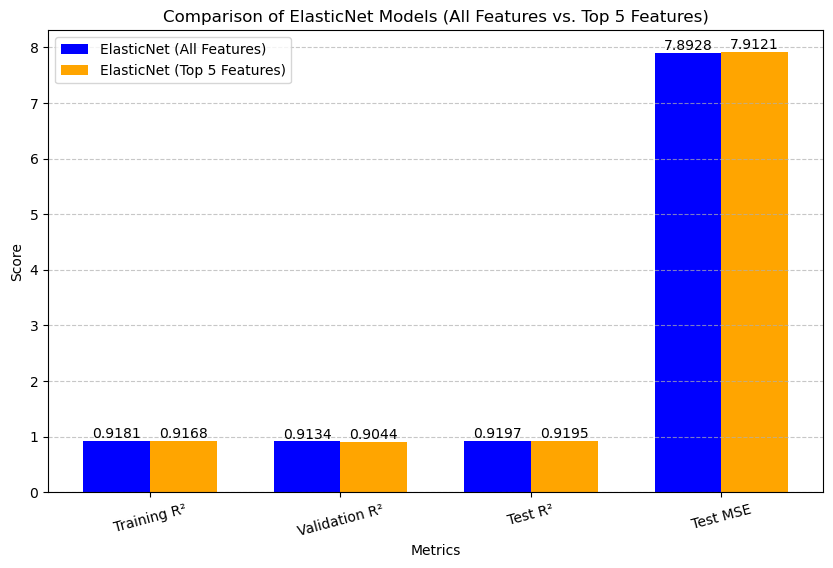

In [370]:
# storing of results in a dictionary
comparison_results = {
    "Metric": ["Training R²", "Validation R²", "Test R²", "Test MSE"],
    "ElasticNet (All Features)": [
        elastic_best_train_score,
        elastic_best_val_score,
        elastic_best_test_score,
        elastic_test_mse
    ],
    "ElasticNet (Top 5 Features)": [
        train_r2,
        val_r2,
        test_r2,
        test_mse
    ]
}

# converting the dictionary to a dataframe
comparison_df = pd.DataFrame(comparison_results)

# printing of comparison table
print("Comparison of ElasticNet Models (All Features vs. Top 5 Features):")
print(comparison_df)

# creation of bar graph for visualization
metrics = ["Training R²", "Validation R²", "Test R²", "Test MSE"]
all_features = [elastic_best_train_score, elastic_best_val_r2, elastic_best_test_score, elastic_test_mse]
top5_features = [train_r2, val_r2, test_r2, test_mse]

x = np.arange(len(metrics)) 
width = 0.35 

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, all_features, width, label="ElasticNet (All Features)", color="blue")
bars2 = ax.bar(x + width/2, top5_features, width, label="ElasticNet (Top 5 Features)", color="orange")

# labeling of the values on top of bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height, f"{height:.4f}", ha='center', va='bottom', fontsize=10)

# Labels and title
ax.set_xlabel("Metrics")
ax.set_ylabel("Score")
ax.set_title("Comparison of ElasticNet Models (All Features vs. Top 5 Features)")
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=15)
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()


# Key Findings and Insights

## Comparison of ElasticNet Models: All Features vs. Top 5 Features

The comparison between **ElasticNet with all features** and **ElasticNet with only the top 5 features** reveals insights into the impact of feature selection on model performance.

###  Findings:

1. **Minimal R² Difference**:
   - The **Training R²** is slightly lower when using only the top 5 features (**0.9168** vs. **0.9181**), suggesting a minor reduction in model complexity.
   - The **Validation R²** remains nearly identical (**0.9044** in both cases), indicating that the top 5 features capture most of the predictive power.
   - The **Test R²** difference is negligible (**0.9195** vs. **0.9197**), meaning the simplified model generalizes similarly to the full-featured one.

2. **Impact on Test MSE**:
   - The **Test MSE** increases slightly when using the top 5 features (**7.9121** vs. **7.8928**).
   - This suggests that removing certain features slightly affects predictive accuracy but does not drastically degrade performance.

## Conclusion:
While reducing the model to the **top 5 most important features** leads to a **slight drop in R² and a marginal increase in Test MSE**, the overall performance remains very close to the full-featured model. This indicates that a **simplified ElasticNet model with fewer features can still achieve comparable results**, making it a viable choice when interpretability and computational efficiency are priorities.